# 사전 학습된 질병 분류기 모델
- https://github.com/manthan89-py/Plant-Disease-Detection/tree/main

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## manthan89의 질병 분류기 모델
- https://github.com/manthan89-py/Plant-Disease-Detection/tree/main

### 이미 학습된 모델 다운로드

In [ ]:
!git clone https://github.com/manthan89-py/Plant-Disease-Detection.git

### 모델 구조 정의
- CNN 사용
- pytorch 사용

In [ ]:
import torch
from torchvision import datasets, transforms, models  # datsets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [ ]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

### 사전에 학습된 가중치 적용

In [ ]:
targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Project/PlantDiseaseDetection/plant_disease_model_1_latest.pt"))
model.eval()

In [ ]:
from torchsummary import summary
input_size = (3, 224, 224)
# 모델의 요약 정보 출력
summary(model, input_size=input_size)

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project/PlantDiseaseDetection/disease_info.csv", encoding="cp1252")

In [ ]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[9:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)

In [ ]:
single_prediction("/content/Plant-Disease-Detection/test_images/corn_common_rust.JPG")

## AI hub 시설 작물 질병 진단 이미지 기반 질병 분류기 모델
- https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=153

### 필요 라이브러리 다운


In [ ]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import DataLoader
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel

### config.py
- 작물 질병 분류 모델 설정

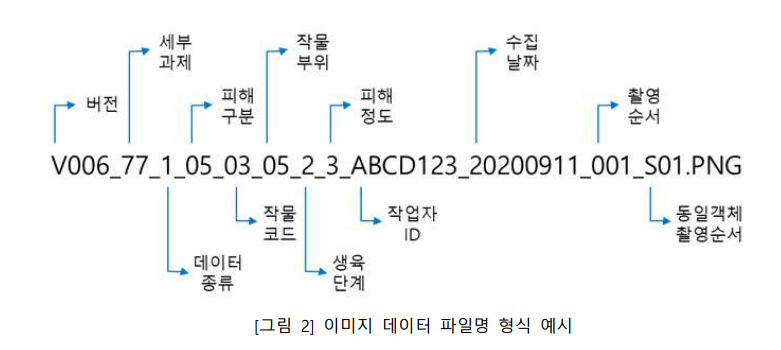

In [ ]:
class config():
    path_prefix = '.'
    path_data = 'dataset'

    # {작물 코드 : {피해 구분(질병 코드)}}
    dict_label = {'10': {'00': 0, '16': 1, '17': 2}}

    # general args
    gpu = 0
    train_size = (512, 512)
    train_model = 'resnet50' #'ENet'
    pnum = 77 # 세부 과제 코드 (77: 시설 작물 질병, 78: 노지작물 해충 등등)
    crop_name = '10' # 작물 코드 - 10 = 참외
    num_classes = 3

    # testing args
    test_model_path = 'weights/sample.pt'

cfg = config()

### utils.py
-  폴더에 있는 이미지 및 라벨 데이터를 처리하는 유틸리티
  - make_data(path,phase): 지정된 폴더에서 이미지 파일 경로를 수집하여 리스트로 반환합니다.
  - cnt_correct(y_true, y_pred): 예측된 결과와 실제 레이블을 기반으로 정확하게 분류된 샘플 수를 계산합니다.
  - log_with_timestamp(msg):현재 시간과 함께 메시지를 출력합니다.
  - bash_cmd(cmd): 주어진 bash 명령을 실행합니다.

In [ ]:
# import os
# import numpy as np
# import torch
import datetime
class utils():
  def make_data(path, phase='train'):
      path_images = []

      for img_name in os.listdir(f'{path}/{phase}'):
          if img_name.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
              path_images.append(f'{path}/{phase}/{img_name}')

      return np.stack(path_images)

  # y_true는 실제 레이블과 y_pred는 예측 결과이다.
  def cnt_correct(y_true, y_pred):
      # topk함수는 텐서 메소드중 하나로 주어진 텐서에서 가장 큰 값 또는 가장 작은 값 및 해당 인덱스를 반환
      # topk(k, dim=None, largest=True, sorted=True)이 형식으로 K는 몇개의 요소를 반환할지 정한다.
      # 값과 인덱스를 반환한다.
      top_N, top_class = y_pred.topk(1, dim=-1)
      # view함수는 텐서의 차원을 변경하는 함수로 topclass와 y_true를 비교하기위해 같은 차원으로 변환후 비교하는 것이다.
      equals = top_class == y_true.view(*top_class.shape)
      return torch.sum(equals.type(torch.FloatTensor)).item()

  def log_with_timestamp(msg):
      print(f'{datetime.datetime.today()} : {msg}')

  def bash_cmd(cmd):
      print()
      _ = os.system(cmd)
      print()
utils = utils()

In [ ]:
pnum = cfg.pnum #세부 과제
crop_name = cfg.crop_name #작물 코드

is_cuda = torch.cuda.is_available()

os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.gpu)

path_images_test = utils.make_data(f'/content/drive/MyDrive/Colab Notebooks/Project/PlantDiseaseDetection/AI_hub_model', 'Test')

def test(model, valid_loader, criterion):
    model.eval()

    list_true = []
    list_pred = []

    loss_sum = 0
    correct_sum = 0

    log_every = len(valid_loader)//5

    len_data = 0

    utils.log_with_timestamp(f'Test ... 0%')

    for i, (image, label, name) in enumerate(valid_loader):
        if is_cuda and cfg.gpu is not None:
            image = image.cuda(cfg.gpu, non_blocking=True)
            label = label.cuda(cfg.gpu, non_blocking=True)

        pred = model(image)

        loss = criterion(pred, label)
        loss_sum += loss.item()

        len_data += image.shape[0]
        correct_sum += utils.cnt_correct(label, pred)

        list_true.append(label.detach().cpu().numpy().flatten())
        list_pred.append(pred.detach().cpu().numpy().argmax(-1).flatten())

        if (i+1)%log_every == 0:
            utils.log_with_timestamp(f'Test ... {((i+1)//log_every)*20}%')

    return loss_sum/len_data, correct_sum/len_data, np.concatenate(list_true, axis=0), np.concatenate(list_pred, axis=0)


def main():
    print('========= Test Environment =========\n')
    _ = utils.bash_cmd('cat /proc/cpuinfo | grep "model name" | uniq')
    _ = utils.bash_cmd('nvidia-smi')
    _ = utils.bash_cmd('free -h')
    _ = utils.bash_cmd('df /')
    _ = utils.bash_cmd('cat /etc/os-release')

    print('\nPyTorch version: ', torch.__version__, '\n')

    utils.log_with_timestamp('Model loading ... ')
    model = get_model(cfg.train_model, cfg.num_classes)
    ckpt = torch.load('/content/drive/MyDrive/Colab Notebooks/Project/PlantDiseaseDetection/sample.pt', map_location='cpu')
    model.load_state_dict(ckpt['model_state_dict'])

    utils.log_with_timestamp('Model compiling ... ')
    criterion = torch.nn.CrossEntropyLoss()

    if cfg.gpu is not None and is_cuda:
        utils.log_with_timestamp(f"Use GPU: {cfg.gpu} for testing")
        torch.cuda.set_device(cfg.gpu)
        model = model.cuda(cfg.gpu)
    else:
        utils.log_with_timestamp('Use CPU, this will be slow')

    test_loader = DataLoader(CustomDataSet(path_images_test, test_aug, test=True), batch_size=1, shuffle=False, num_workers=0)

    print('\n===== Start testing =====\n')
    test_loss, test_acc, list_true, list_pred = test(model, test_loader, criterion)

    print('\n===== Test result =====\n')
    print(classification_report(list_true, list_pred, digits=5))
    print('\n========= Confusion Matrix =========\n')
    for rr in confusion_matrix(list_true, list_pred):
        print(rr)

    print('\nLog csv ... ')
    df = pd.DataFrame({'image_name': path_images_test,
                       'true': list_true,
                       'pred': list_pred})

    df.to_csv(f'{pnum}_{crop_name}_log_each_sample.csv')

    print('\n===== Finished testing =====')

    _ = utils.bash_cmd('sh rm_cache.sh')

if __name__ == '__main__':
    main()